In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import h5py
import os
import pathlib

In [3]:
import logging
logger = logging.getLogger(__name__)

In [4]:
from dedalus import public as de
from dedalus.extras import flow_tools 
from dedalus.tools import post

In [5]:
CACHE_OK = True

In [8]:
def solve_toy_problem(probid, Nx=4096, r0=1e-4, K=0, delta0=-7, delta2=10, q=3, dt=1e-5, tmax=0.20001):

    # set-up for output
    dirname = f'analysis-{probid}'
    filename = os.path.join(dirname, "analysis.h5")
    
    # don't accidently re-solve the problem
    if CACHE_OK:
        return filename
    
    # pick basis and domain
    x_basis = de.Chebyshev('x', Nx, interval=(r0,1), dealias=3/2)
    domain = de.Domain([x_basis], np.float64)

    x = domain.grid(0)
    
    delta = domain.new_field()
    delta['g'] = delta0 - delta2 * x * x
    
    # Problem
    problem = de.IVP(domain, variables=['T', 'Tx', 'Y', 'theta'])
    problem.parameters['K'] = K
    problem.parameters['q'] = q
    problem.parameters['delta'] = delta
    problem.parameters['delta0'] = delta0

    problem.meta['Tx']['x']['dirichlet'] = True
    
    # sub-threshold electron capture rate
    problem.substitutions['dYdt'] = "-Y * T**3 * exp((delta-delta0*T)/T)"
    
    # Laplacian in spherical coordinates
    problem.substitutions['Laplacian_T'] = "dx(Tx) + 2 * Tx / x"

    # This is the heat equation with source term
    problem.add_equation("x * (dt(T) - K * Laplacian_T) = -x * (q * dYdt)")
    problem.add_equation("Tx - dx(T) = 0")
    problem.add_equation("dt(Y) = dYdt")
    problem.add_equation("dt(theta) = Laplacian_T")
    problem.add_bc('left(Tx) = 0')
    problem.add_bc('right(Tx) = 0')
    
    # Build solver
    solver = problem.build_solver(de.timesteppers.SBDF1)
    solver.stop_wall_time = 60*10
    solver.stop_sim_time = tmax
    solver.stop_iteration = np.inf

    # Initial conditions
    T = solver.state['T']
    Tx = solver.state['Tx']
    T['g'] = np.ones_like(x)
    T.differentiate(0, out=Tx)

    Y = solver.state['Y']
    Y['g'] = 1
    
    theta = solver.state['theta']
    theta['g'] = 0

    # Set up output
    analysis = solver.evaluator.add_file_handler(dirname, iter=5, max_writes=10000)
    analysis.add_system(solver.state, layout='g')
    analysis.add_task("dYdt",name="dYdt")
    analysis.add_task("Laplacian_T",name="Laplacian_T")
    analysis.add_task("dx(Y)", layout='g', name='Yx')
    analysis.add_task("dx(theta)", layout='g', name='thetax')


    # Do solve
    while solver.ok:
        solver.step(dt)
        if solver.iteration % 1000 == 0:
            logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))


    # post-process output
    post.merge_process_files(dirname, cleanup=True)
    set_paths = list(pathlib.Path(dirname).glob(f"{dirname}_s*.h5"))
    post.merge_sets(filename, set_paths, cleanup=True)
    return filename

# No diffusion (K=0)

In [29]:
nodiff = solve_toy_problem("nodiff", K=0)

Choose which Ts to plot.

In [8]:
with h5py.File(nodiff, mode='r') as file:
        
    xs = file['scales']['x']['1.0'][:]
    ts = file['scales']['sim_time'][:]

    # want to plot first profile
    which_profiles = [0]
    dY = 0.2
    Ytarget = 1.0 - dY
    for i, t in enumerate(ts):
        Yc = file['tasks']['Y'][i,0]
        if Yc < Ytarget:
            which_profiles.append(i)
            Ytarget -= dY
        if Yc <= 1e-4:
            which_profiles.append(i)
            irunaway = i
            trunaway = t
            break
    
    times = [0.05, 0.1, 0.15, 0.2]
    for t in times:
        i = np.argmin(np.abs(ts-t))
        if i > irunaway:
            t = ts[i]
            which_profiles.append(i)
    
    print(f'trunaway = {trunaway}')
    for i in which_profiles:
        print(i, ts[i], file['tasks']['Y'][i,0])

trunaway = 0.04415000000000285
0 0.0 1.0
821 0.04105 0.797831087127
857 0.04285 0.597979607621
866 0.0433 0.36680015552
870 0.0435 0.160589387478
883 0.04415 7.56464992049e-05
1000 0.05 1.11022302463e-16
2000 0.1 4.51923720668e-10
3000 0.15 -9.85846404511e-10
4000 0.2 1.14473492352e-08


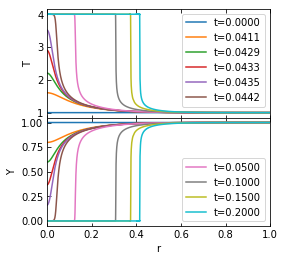

In [9]:
fig, axs = plt.subplots(2)
with h5py.File(nodiff, mode='r') as file:

    xs = file['scales']['x']['1.0']
    ts = file['scales']['sim_time']

    for n, i in enumerate(which_profiles):
        t = ts[i]
        l = f't={t:6.4f}'
        Ts = file['tasks']['T'][i,:]
        Ys = file['tasks']['Y'][i,:]
        if n< 6:
            axs[0].plot(xs, Ts, label=l)
            axs[1].plot(xs, Ys)
        else:
            axs[0].plot(xs, Ts)
            axs[1].plot(xs, Ys, label=l)

axs[0].set_ylabel('T')
axs[1].set_ylabel('Y')
axs[0].legend(loc=1)
axs[1].legend(loc=4)
axs[1].set_xlabel('r')
axs[0].xaxis.set_label_position('top')
for ax in axs:
    ax.set_xlim(0,1)

axs[0].tick_params(top=True, bottom=True, direction='in', labelbottom=False)    
axs[1].tick_params(top=True, bottom=True, direction='in')

fig.set_size_inches(4,4)
fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('../paper/figures/TY_K0.pdf', bbox_inches='tight')

Now calculate minimum length scale

0.0324371353738


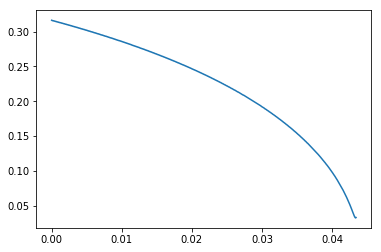

In [10]:
fig, ax = plt.subplots()

xv = []
yv = []
with h5py.File(nodiff, mode='r') as file:
        
    xs = file['scales']['x']['1.0']
    ts = file['scales']['sim_time']

    for i, t in enumerate(ts):
        dYdt = -file['tasks']['dYdt'][i,:]
        
        # only look when peak rate is at center
        if np.argmax(dYdt) !=0: break
            
        idx = np.argmin(np.abs(dYdt-dYdt[0]/np.exp(1)))
        xv.append(t)
        yv.append(xs[idx])

ax.plot(xv, yv)
print(np.array(yv).min())

Now look at theta

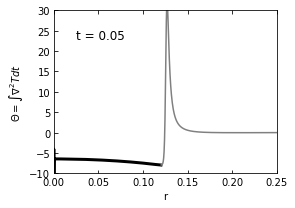

In [119]:
fig, ax = plt.subplots()
with h5py.File(nodiff, mode='r') as file:

    xs = file['scales']['x']['1.0'][:]
    ts = file['scales']['sim_time'][:]

    i = np.argmin(np.abs(ts-0.05))
    Ys = file['tasks']['Y'][i,:]
    j = np.argmin(np.abs(Ys-1e-4))
    theta = file['tasks']['theta'][i,:]
    ax.plot(xs[:j], theta[:j], color='black', lw=3)
    ax.plot(xs[j:], theta[j:], color='grey')

ax.set_xlim(0.0, 0.25)
ax.set_xlabel('r')
ax.set_ylim(-10, 30)
ax.set_ylabel(r'$\Theta = \int \nabla^2 T dt$')
ax.text(0.025, 23, 't = 0.05', size=12)
ax.tick_params(top=True, bottom=True, direction='in')
fig.set_size_inches(4,3)
#fig.savefig('../paper/figures/theta_K0.pdf', bbox_inches='tight')

In [12]:
def plot_stability(filename, x0=1e-3, ymin=1e-6, ymax=1, title=None, add_annotations=False):

    fig, ax = plt.subplots()
    xs = np.logspace(-6, 1, 10)
    ax.plot(xs, xs/3.0, color='grey', ls='--', zorder=3, alpha=0.67)
    
    with h5py.File(filename, mode='r') as file:
        ts = file['scales']['sim_time']
        xs = np.array(file['scales']['x']['1.0'])
        
        idx = np.argmin(np.abs(xs-x0))
        
        Yxs = file['tasks']['Yx'][:,idx]
        Ys = file['tasks']['Y'][:,idx]
        Txs = file['tasks']['Tx'][:,idx]
        Ts = file['tasks']['T'][:,idx]


        ok = (ymin < Ys) & (Ys < ymax)
        Txmin = np.min(Txs[ok])
        Yxmax = np.max(Yxs[ok])
        nonB = -Txs[ok]/Ts[ok]
        B = Yxs[ok]/Ts[ok]
        s=1
        c = ax.scatter(nonB[::s], B[::s], c=Ys[ok][::s], alpha=0.5, vmin=0.0, vmax=1.0)
        
        print(np.max(ts[ok]))

    if title is not None: ax.set_title(title)
    ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    cbar = fig.colorbar(c)
    cbar.ax.set_ylabel('Y')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$-\frac{1}{T}\frac{dT}{dr}$ (proxy for $\delta_\nabla$)')
    ax.set_ylabel(r'$\frac{1}{T}\frac{dY}{dr}$ (proxy for $B$)')

    ax.set_xlim(1e-5, 2)    
    ax.set_ylim(1e-5, 2)
    
    ax.set_aspect('equal')
    tks = np.logspace(-5,0,6)
    ax.set_xticks(tks)
    ax.set_yticks(tks)
    
    if add_annotations:
        bbox_props = dict(boxstyle="rarrow,pad=0.3", fc='white', ec="black", lw=2)
        t = ax.text(0.1, 2e-4, "more unstable \n less stable", ha="center", va="center", rotation=-45,
            size=8,
            bbox=bbox_props)
        #bb = t.get_bbox_patch()
        #bb.set_boxstyle("rarrow", pad=0.6)
        bbox_props = dict(boxstyle="larrow,pad=0.3", fc='white', ec="black", lw=2)
        t = ax.text(2e-4, 0.1, "more stable \n less unstable", ha="center", va="center", rotation=-45,
            size=8,
            bbox=bbox_props)

    return fig, ax

0.1993


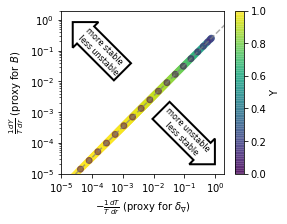

In [13]:
fig, ax = plot_stability(nodiff, add_annotations=True)
fig.set_size_inches(4,3)
fig.savefig('../paper/figures/stability_K0.pdf', bbox_inches='tight')

# Finite diffusion

In [9]:
lodiff = solve_toy_problem("lodiff", K=0.01)

0.0451


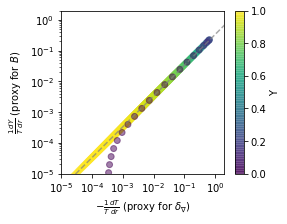

In [15]:
fig, ax = plot_stability(lodiff)
fig.set_size_inches(4,3)
fig.savefig('../paper/figures/stability_Klo.pdf', bbox_inches='tight')

In [62]:
def pick_profiles(ts, Ycs):
    which_profiles = [0]
    dY = 0.2
    Ytarget = 1.0 - dY
    for i, t in enumerate(ts):
        Ycm = Ycs[i]
        Ycp = Ycs[i+1]
        if Ycp < Ytarget < Ycm:
            if abs(Ycm-Ytarget) < abs(Ycp-Ytarget):
                which_profiles.append(i)
            else:
                which_profiles.append(i+1)    
            print(Ycp, Ytarget, Ycs[which_profiles[-1]], Ycm)
            Ytarget -= dY
        if Ycm <= 1e-4:
            which_profiles.append(i)
            irunaway = i
            trunaway = t
            break
    return which_profiles

0.798835873689 0.8 0.800989162851 0.800989162851
0.591039028984 0.6000000000000001 0.60472388307 0.60472388307
0.372145801547 0.4000000000000001 0.409575631988 0.409575631988
0.18216301607 0.20000000000000007 0.18216301607 0.233392639784
0.797831087127 0.8 0.800115525343 0.800115525343
0.597979607621 0.6000000000000001 0.597979607621 0.611898512363
0.36680015552 0.4000000000000001 0.407428677966 0.407428677966
0.160589387478 0.20000000000000007 0.215138137023 0.215138137023
(0.85001134689337754, 4.1497617152390704)


/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


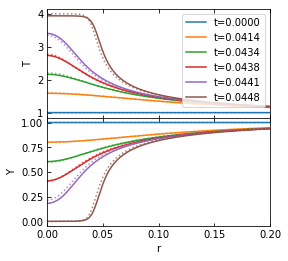

In [63]:
fig, axs = plt.subplots(2)
with h5py.File(lodiff, mode='r') as file:

    xs = file['scales']['x']['1.0'][:]
    ts = file['scales']['sim_time'][:]
    Ycs = file['tasks']['Y'][:,0]

    which_profiles = pick_profiles(xs, Ycs)
    
    for n, i in enumerate(which_profiles):
        t = ts[i]
        l = f't={t:6.4f}'
        Ts = file['tasks']['T'][i,:]
        Ys = file['tasks']['Y'][i,:]
        axs[0].plot(xs, Ts, label=l)
        axs[1].plot(xs, Ys)

for ax in axs:
    ax.set_prop_cycle(None)
            
            
with h5py.File(nodiff, mode='r') as file:

    xs = file['scales']['x']['1.0'][:]
    ts = file['scales']['sim_time'][:]
    Ycs = file['tasks']['Y'][:,0]

    which_profiles = pick_profiles(xs, Ycs)
    
    for n, i in enumerate(which_profiles):
        t = ts[i]
        l = f't={t:6.4f}'
        Ts = file['tasks']['T'][i,:]
        Ys = file['tasks']['Y'][i,:]
        axs[0].plot(xs, Ts, alpha=0.75, ls='dotted')
        axs[1].plot(xs, Ys, alpha=0.75, ls='dotted')
     

axs[0].set_ylabel('T')
axs[1].set_ylabel('Y')
axs[0].legend(loc=1)
axs[1].legend(loc=4)
axs[1].set_xlabel('r')
axs[0].xaxis.set_label_position('top')
for ax in axs:
    ax.set_xlim(0,0.2)
print(axs[0].get_ylim())
    
axs[0].tick_params(top=True, bottom=True, direction='in', labelbottom=False)    
axs[1].tick_params(top=True, bottom=True, direction='in')

fig.set_size_inches(4,4)
fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('../paper/figures/TY_Klo.pdf', bbox_inches='tight')

In [13]:
hidiff = solve_toy_problem("hidiff", K=0.1)

0.051


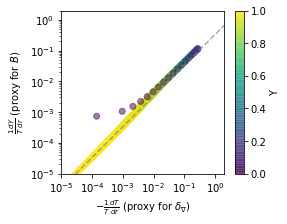

In [17]:
fig, ax = plot_stability(hidiff)
fig.set_size_inches(4,3)
fig.savefig('../paper/figures/stability_Khi.pdf', bbox_inches='tight')

0.799054756321 0.8 0.80054716317 0.80054716317
0.59580842503 0.6000000000000001 0.59580842503 0.604212289379
0.398817922194 0.4000000000000001 0.398817922194 0.420419058445
0.170657839845 0.20000000000000007 0.202030721879 0.202030721879
0.797831087127 0.8 0.800115525343 0.800115525343
0.597979607621 0.6000000000000001 0.597979607621 0.611898512363
0.36680015552 0.4000000000000001 0.407428677966 0.407428677966
0.160589387478 0.20000000000000007 0.215138137023 0.215138137023


/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


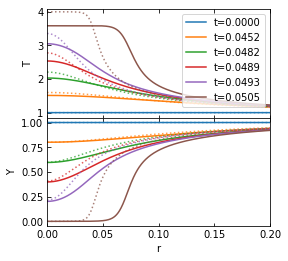

In [64]:
fig, axs = plt.subplots(2)
with h5py.File(hidiff, mode='r') as file:

    xs = file['scales']['x']['1.0'][:]
    ts = file['scales']['sim_time'][:]
    Ycs = file['tasks']['Y'][:,0]

    which_profiles = pick_profiles(xs, Ycs)
    
    for n, i in enumerate(which_profiles):
        t = ts[i]
        l = f't={t:6.4f}'
        Ts = file['tasks']['T'][i,:]
        Ys = file['tasks']['Y'][i,:]
        axs[0].plot(xs, Ts, label=l)
        axs[1].plot(xs, Ys)

for ax in axs:
    ax.set_prop_cycle(None)
            
            
with h5py.File(nodiff, mode='r') as file:

    xs = file['scales']['x']['1.0'][:]
    ts = file['scales']['sim_time'][:]
    Ycs = file['tasks']['Y'][:,0]

    which_profiles = pick_profiles(xs, Ycs)
    
    for n, i in enumerate(which_profiles):
        t = ts[i]
        l = f't={t:6.4f}'
        Ts = file['tasks']['T'][i,:]
        Ys = file['tasks']['Y'][i,:]
        axs[0].plot(xs, Ts, alpha=0.75, ls='dotted')
        axs[1].plot(xs, Ys, alpha=0.75, ls='dotted')
     
axs[0].set_ylabel('T')
axs[1].set_ylabel('Y')
axs[0].legend(loc=1)
axs[1].legend(loc=4)
axs[1].set_xlabel('r')
axs[0].xaxis.set_label_position('top')
axs[0].set_ylim(0.85303109069053307, 4.0863470954988053)
for ax in axs:
    ax.set_xlim(0,0.2)

axs[0].tick_params(top=True, bottom=True, direction='in', labelbottom=False)    
axs[1].tick_params(top=True, bottom=True, direction='in')

fig.set_size_inches(4,4)
fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('../paper/figures/TY_Khi.pdf', bbox_inches='tight')